# 运动前景检测

## 实验目的
自选一段视频，编程实现基于混合高斯模型的运动前景检测。

## 实验环境
- OpenCV
- MatPlotLib
- NumPy

## 实验原理

### MOG
MOG（混合高斯模型）是一种用于背景减除的统计方法，它通过为每个像素点建模，使用多个高斯分布来描述像素的值随时间变化的情况。其核心思想是：对于每个像素点的颜色值，可以由多个高斯分布的加权混合模型来描述，进而区分前景和背景。

每个像素点的颜色值（通常使用RGB或灰度值）被看作是一个随机变量，可以用高斯分布来建模。对每个像素，我们定义 $K$ 个高斯分布的混合模型。每个像素的颜色值 $X_t$ 在时刻 $t$ 上的概率分布可以表示为：

$$
P(X_t) = \sum_{i=1}^{K} w_{i,t} \cdot \mathcal{N}(X_t | \mu_{i,t}, \Sigma_{i,t})
$$

其中：
- $w_{i,t}$ 是第 $i$ 个高斯分布在时刻 $t$ 的权重，表示该高斯分布对当前像素状态的贡献；
- $\mathcal{N}(X_t | \mu_{i,t}, \Sigma_{i,t})$ 表示第 $i$ 个高斯分布的概率密度函数，其均值为 $\mu_{i,t}$，协方差为 $\Sigma_{i,t}$；
- $K$ 是高斯分布的数量，通常取 $3$ 到 $5$。

#### 前景和背景判断
对于每一帧中的像素值 $X_t$，我们将其与每个高斯分布进行比较。如果 $X_t$ 与某个高斯分布的均值 $\mu_{i,t}$ 的差距小于某个阈值，则认为该像素属于背景。否则，该像素可能是前景：

$$
|X_t - \mu_{i,t}| < T \cdot \sigma_{i,t}
$$

其中 $T$ 是预设的阈值，$\sigma_{i,t}$ 是第 $i$ 个高斯分布的标准差。

如果没有找到匹配的高斯分布，则认为该像素是前景，并且创建一个新的高斯分布来更新模型。

#### 参数更新
模型中的每个高斯分布的均值和协方差会随着时间进行更新，以适应背景的缓慢变化。每个分布的更新公式如下：

$$
\mu_{i,t+1} = \alpha \cdot X_t + (1 - \alpha) \cdot \mu_{i,t}
$$

$$
\sigma_{i,t+1}^2 = \alpha \cdot (X_t - \mu_{i,t})^2 + (1 - \alpha) \cdot \sigma_{i,t}^2
$$

其中 $\alpha$ 是学习率，决定模型更新的速度。

#### MOG2

MOG2 是对 MOG 算法的改进，主要解决了 MOG 在处理光照变化、动态背景和阴影等复杂场景时的不足。MOG2 引入了自适应学习率和阴影检测，使得它在现实应用中更加稳定和精确。在OpenCV中，`cv2.createBackgroundSubtractorMOG2`可以创建基于MOG2的背景减除器，其带有参数：

- `history`：决定背景模型更新的历史帧数，控制背景模型记忆的时间长度。
- `varThreshold`：定义前景和背景分离的阈值，影响前景检测的敏感度。
- `detectShadows`：是否启用阴影检测，启用后阴影会被标记为灰色。

创建的背景减除器对象带有方法：

- `apply()`：应用背景减除算法到每一帧图像，生成前景掩码。
- `getBackgroundImage()`：获取当前的背景图像。
- `clear()`：仅适用于 KNN 方法，清除模型。
- `setDetectShadows()` 和 `getDetectShadows()`：设置和获取阴影检测的状态。

### 视频捕获

在 OpenCV 中，使用 `cv2.VideoCapture` 类来捕获视频。

带有方法：
- `VideoCapture(video_source)`：`video_source` 可以是视频文件的路径或摄像头索引（通常为 0 或 1）。
- `read()`：从视频流中读取下一帧，返回一个布尔值和帧（布尔值指示是否成功读取帧）。
- `get(property)`：获取视频的属性（如帧宽度、高度、帧率等）。
- `release()`：释放捕获对象，关闭视频文件或摄像头。

Total Frames: 91
Length of Sampled Frames: 6


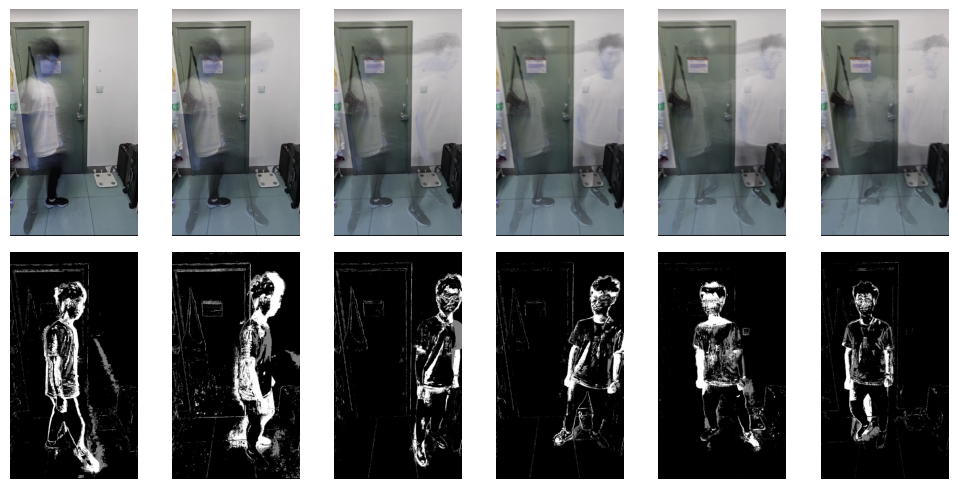

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 创建视频捕获对象
video_path = 'example.mp4'
cap = cv2.VideoCapture(video_path)

# 创建MOG2背景减法器对象
subtractor = cv2.createBackgroundSubtractorMOG2(history=50, 
                                                varThreshold=16, 
                                                detectShadows=True)

# 计算总帧数和中间帧位置
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total Frames: {total_frames}")
STEP = 15

# 存储背景模型和前景帧
backgrounds: list[np.ndarray] = []
foregrounds: list[np.ndarray] = []

# 遍历视频帧
frame_idx = 0
for frame_idx in range(total_frames):
    ret, frame = cap.read()
    fore_mask = subtractor.apply(frame)
    
    if (frame_idx+1) % STEP == 0:
        backgrounds.append(subtractor.getBackgroundImage())
        foregrounds.append(fore_mask)
    
    
cap.release()
print(f"Length of Sampled Frames: {len(backgrounds)}")

# 显示背景和前景
fig, axes = plt.subplots(2, len(backgrounds), figsize=(10, 5))

# 显示背景
for i, background in enumerate(backgrounds):
    axes[0, i].imshow(background.astype('uint8'), cmap='gray')
# 显示前景
for i, foreground in enumerate(foregrounds):
    axes[1, i].imshow(foreground.astype('uint8'), cmap='gray')

# 去除坐标轴
for ax in axes.flatten():
    ax.axis('off')

# 显示图像
plt.tight_layout()
plt.show()


可以看到，随着学习帧数的增多，背景渐渐分离；即使到了最后，也有一点前景人物的残影。前景掩码的检测很不错，但门框等位置可能由于相机抖动被错误纳入了前景的范围。